In [1]:
import numpy as np
from matplotlib import pyplot as plt
from isr_psych_models import MultiTrialSEM

In [11]:
params_SEM = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.08, 'G_p':0.0, 'R_s': 0.50, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 1.0, 'C_p': 1, 'C_d': 0, 'C_r': 1, 'C_i':0, 'C_a': 5, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':12, 'max_tokens':30}
num_trials = 1000
list_length = 6
group_length = 6
C_i_arr = [0, 4, 16, 36]
perf_c_i = []
intrusions_c_i = []
immediate_intrusions_c_i = []
output_protrusions_c_i = []
for c_i in C_i_arr:
    params_SEM['C_i'] = c_i
    mtSEM_5 = MultiTrialSEM(params_SEM)
    mtSEM_5.simulate_trials_SEM(num_trials, list_length, group_length)
    perf_c_i.append(mtSEM_5.num_correct / num_trials)
    intrusions_c_i.append(mtSEM_5.num_intrusions)
    immediate_intrusions_c_i.append(mtSEM_5.num_immediate_intrusions)
    output_protrusions_c_i.append(mtSEM_5.num_output_protrusions)
    print(f"PPR: {mtSEM_5.num_correct / num_trials}")
    print(f"Num omissions: {mtSEM_5.num_omissions}")
    print(f"Num intrusions: {mtSEM_5.num_intrusions}")
    print(f"Num immediate intrusions: {mtSEM_5.num_immediate_intrusions}")
    print(f"Num protrusions: {mtSEM_5.num_output_protrusions}")

KeyboardInterrupt: 

In [2]:
class MultiTrialSEM():

    '''
    This class implements to multi-trial version of SEM, as described by Henson (1998).
    Limited to grouping at a single level, will extend later if needed.
    '''

    def __init__(self, param_dict):

        '''
         param_dict contains the following keys: 

        :param float s0: initial strength of start marker 
        :param float e0: initial strength of end marker
        :param float S: change rate for start marker
        :param float E: change rate for end marker
        :param float E_c: contextual drift
        :param float G_c: std. dev. of zero mean gaussian dist. for recall selection process 
        :param float G_p: std. dev. of zero mean gaussian dist. for phonological selection process 
        :param float A_p: phonological representation
        :param flaot P_s: phonological similarity for confusable items
        :param float P_d: phonological similarity for non-confusable items 
        :param float R_s: decay rate for response suppression 
        :param float R_p: decay rate for phonological activations
        :param float T_o: threshold for response 
        :param int C_p: number of episodes between presentation of each item 
        :param int C_d: number of episodes between during the retention interval 
        :param int C_r: number of episodes between recall of each item 
        :param int C_i: number of episodes between trials
        :param int C_a: additional contextual change between trials 
        :param int vocab_size: number of items/items 
        '''
        self.s0 = param_dict['s0'] 
        self.e0 = param_dict['e0'] 
        self.S = param_dict['S'] 
        self.E = param_dict['E'] 
        self.E_c = param_dict['E_c'] 
        self.E_l = param_dict['E_l'] 
        self.G_c = param_dict['G_c'] 
        self.G_p = param_dict['G_p']
        self.A_p = param_dict['A_p']
        self.P_s = param_dict['P_s']
        self.P_d = param_dict['P_d']
        self.R_s = param_dict['R_s']
        self.R_p = param_dict['R_p']
        self.T_o = param_dict['T_o']
        self.C_p = param_dict['C_p']
        self.C_d = param_dict['C_d']
        self.C_r = param_dict['C_r']
        self.C_i = param_dict['C_i']
        self.C_a = param_dict['C_a']
        self.vocab_size = param_dict['vocab_size'] # number of types in LTM 
        self.max_tokens = param_dict['max_tokens'] # max number of tokens that can be stored, somewhat arbitrary
        self.present_context = 1
        self.suppression = 1 
        self.list_position_tokens = [] # stores start and end markers for list position
        self.group_position_tokens = [] # stores start and end markers for group position 
        self.stored_tokens = [] # stores only tokens that are in SEM, this is used by SEM
        self.context_tokens = [] # stores context markers 
        self.response_suppression = np.zeros(self.vocab_size)
        self.phonological_activations = np.zeros(self.vocab_size)
        self.num_correct = 0 # number of lists recalled correctly
        self.num_omissions = 0 
        self.num_intrusions = 0
        self.num_immediate_intrusions = 0 
        self.num_output_protrusions = 0 
        self.recalled_list = [] # stores recalled items of current trials 
        self.current_list = [] # stores items of currently presented list
        self.all_stored_tokens = [] 
        self.all_context_tokens = [] 
        self.all_list_position_tokens = []
        self.all_group_position_tokens = []

    def start_end_markers(self, list_length, group_size, list_pos, group_pos):

        '''
        Generates start and end markers indicating list position and group position. 

        :param int list_length: length of entire list
        :param int group_size: size of a group 
        :param int list_pos: position of item on list
        :param int group_num: group number that item belongs in 
        '''

        list_pos_marker = np.asarray([np.round(self.s0*self.S**(list_pos-1.0),2), np.round(self.e0*self.E**(list_length-list_pos), 2)])
        group_pos_marker = np.asarray([np.round(self.s0*self.S**(group_pos-1.0),2), np.round(self.e0*self.E**(group_size-group_pos), 2)])

        return list_pos_marker, group_pos_marker

    def overlap_function(self, p_j, p_t):

        '''
        Computes the overlap between between two vectors 

        :param list p_j: 2x1  positional for response j, or 1x1  contextual marker 
        :param list p_t: 2x1 positional cue for item presented 
        at time t during the presentation phase
        '''

        exp_term = np.exp(-np.sum((p_t - p_j)**2)**.5)

        return np.round(np.dot(p_j, p_t)**.5 * exp_term, 5)

    def positional_cues(self, n, plot=False):

        '''
        :param int n: length of list 
        '''

        pos_matrix = np.zeros((n, ))

        s_arr = [] # start marker array
        e_arr = [] # end marker array
        c_arr = np.ones(n) # context markers 

        for i in range(n):
            s, e = self.start_end_markers(i+1)
            s_arr.append(s)
            e_arr.append(e)
            c_arr[:i+1] = c_arr[:i+1] * self.E_c
            
        if plot: 
            plt.plot(s_arr, marker='o')
            plt.plot(e_arr, marker='o')
            plt.title("Positional cues")
            plt.show()

        return s_arr, e_arr, c_arr

    def positional_overlap(self, n, plot=False):

        for i in range(n):
            pos_sim = []
            for j in range(n):
                s, e =self.start_end_markers(i+1)
                s2, e2 = self.start_end_markers(j+1)
                p1 = np.asarray((s,e))
                p2 = np.asarray((s2, e2))
                o = self.overlap_function(p1, p2)
                pos_sim.append(o)
            if plot:
                plt.plot(pos_sim, marker='o')

        if plot:
            plt.title("Positional overlap")
            plt.show()

        return pos_sim 

    def add_token(self, item, list_position, group_position, phono_activation, context, suppression):

        '''
        Add tokens and modify phonological + suppression type representations 

        :param int item: integer corresponding to item 
        :param list list_position: start and end values coding list position
        :param list group_position: start and end values coding group position
        :param float phono_activation: how much to boost phonological type representation 
        :param float context: context value of token 
        :param float suppression: response suppression value of type representation 
        '''
        
        # ensure stored tokens are all the same length 
        assert len(self.stored_tokens) == len(self.list_position_tokens) == \
        len(self.group_position_tokens) == len(self.context_tokens), \
        print("Token lengths are not matching.")

        # if at max limit, pop first token from all lists 
        if len(self.stored_tokens) == self.max_tokens:
            self.stored_tokens.pop(0)
            self.list_position_tokens.pop(0)
            self.group_position_tokens.pop(0)
            self.context_tokens.pop(0)

        self.stored_tokens.append(item)
        self.list_position_tokens.append(list_position)
        self.group_position_tokens.append(group_position)
        self.context_tokens.append(context)

        # modify response suppression and phonological attributes of type representations
        self.response_suppression[item] = suppression
        self.phonological_activations[item] = phono_activation

    def list_presentation(self, list_length, group_size, items):

        '''
        :param int list_length: 
        :param int group_size 
        :param list items: each element is an integer corresponding to a item(0 is A, 25 is Z)
        '''

        # before presenting new items
        self.contextual_change_acrosstrials()
        self.current_list = items 
        self.previously_recalled_list = self.recalled_list
        self.recalled_list = []

        for lp, item in enumerate(items):
            
            # between presentation of each item incorporate C_p episodes of 
            # contextual + phonological + response suppression (rs) decay
            if lp != 0:
                for i in range(self.C_p):
                    self.decay_context_phono_rs()

            # obtain start and end markers for list and group position 
            gp = lp % group_size
            lp_marker, gp_marker = self.start_end_markers(list_length, group_size, lp+1, gp+1)
            self.add_token(item, lp_marker, gp_marker, self.A_p, self.present_context, 1-self.suppression)

            
        # model effects of retention interval
        for i in range(self.C_d):
            self.decay_context_phono_rs()

    def contextual_change_acrosstrials(self):
        
        # contextual decay for C_a + C_i episodes
        for i in range(self.C_a+self.C_i):
            self.context_tokens = [x*self.E_c for x in self.context_tokens]
            self.list_position_tokens = [x*self.E_l for x in self.list_position_tokens]

            # phonological decay for C_i episodes 
            if i > self.C_a:
                self.phonological_activations *= np.exp(-self.R_p)

    def decay_context_phono_rs(self):

        '''
        Performs one timestep of decay on contextual + phonological informatiton 
        '''

        self.context_tokens = [x*self.E_c for x in self.context_tokens]
        self.phonological_activations *= np.exp(-self.R_p)
        self.response_suppression *= np.exp(-self.R_s)


    def recall_selection(self, recall_list_cue, recall_group_cue, grouping=False):

        '''
        Input: 
        :param int recall_list_cue: list position used to initiate recall 
        :param int recall_group_cue: group position used to initiate recall 

        Output: 
        item selected for retrieval, or if no item was selected an omission response. 
        '''

        # init. all type strengths to 0 
        # although SEM stores episodic tokens in STM, the response competition phase
        # is performed over the type representations in LTM.

        type_strengths = np.zeros(self.vocab_size)

        # obtain start and end markers based on cue
        rl_query, rg_query = self.start_end_markers(self.list_length, self.group_size, recall_list_cue, recall_group_cue)

        # compute overlap between retreival position + contextual cues and stored tokens
        # store the maximum overlap strength for each type representation 
        for i in range(len(self.list_position_tokens)):  

            # record item 
            item = int(self.stored_tokens[i])

            # skip if item is an omission response 
            if item == -1:
                continue

            # overlap between query list position (lp) and stored list position tokens 
            o_lp = self.overlap_function(rl_query, self.list_position_tokens[i])
            
            if grouping:
                o_gp = self.overlap_function(rg_query, self.group_position_tokens[i])
            else:
                o_gp = 1 # if no grouping, set group overlap strength to 1 

            o_c = self.overlap_function(self.present_context, self.context_tokens[i]) # will bias retrieval towards most recent tokens 

            overlap_strength = o_lp*o_gp*o_c*(1-self.response_suppression[item]) 
            
            # only store max overlap strength value for each item 
            if type_strengths[item] < overlap_strength:
                type_strengths[item] = overlap_strength
                
        # add noise to type strengths 
        type_strengths += np.random.default_rng().normal(0, self.G_c, type_strengths.shape[0])

        self.type_strengths = type_strengths

        recalled_item = self.phonological_selection(type_strengths)

        self.recalled_list.append(recalled_item)

        # if recalled item is not in the presented + not an omission, it is an intruson 
        if recalled_item not in self.current_list and ~np.isnan(recalled_item):
            self.num_intrusions += 1
            # check if there is a previously recalled list
            if len(self.previously_recalled_list) != 0:
                # check if recalled item is an immediate intrusion 
                if recalled_item in self.previously_recalled_list:
                    self.num_immediate_intrusions += 1
                    # check if immediate intrusion is an output protrusion 
                    ii_pos = np.argwhere(recalled_item == np.array(self.previously_recalled_list))[0][0] + 1
                    if ii_pos == recall_list_cue:
                        self.num_output_protrusions += 1
                

        # decay values after recalling an item 
        for i in range(self.C_r):
            self.decay_context_phono_rs()
       
        # recode recalled_item as a new token 
        # if omission response, record everything as -1 
        if np.isnan(recalled_item):
            self.add_token(-1, np.asarray([-1,-1]), np.asarray([-1,-1]), -1, -1, -1)
        else:
            self.add_token(int(recalled_item), rl_query, rg_query, self.A_p, self.present_context, self.suppression)

    def phonological_sim(self, item1, item2):

        if item1 == item2:
            return 1
            
        # assume all items are non-confusable for now 
        else:
            return self.P_d

    def phonological_selection(self, type_strengths):

        # strongest item from cueing stage 
        strongest_item = np.argmax(type_strengths)
        type_strengths_phono = np.zeros(self.vocab_size)

        if strongest_item in self.current_list:
            self.phonological_activations[strongest_item] = self.A_p

        # incorporate effects of phonological similarity
        for item, ts in enumerate(type_strengths):

            # provide a boost to items that are phonologically similar to the strongest activated item 
            phono_boost =  self.phonological_sim(item, strongest_item) * \
            self.phonological_activations[strongest_item]*(1-self.response_suppression[item])
            type_strengths_phono[item] = ts + phono_boost

        type_strengths_phono += np.random.default_rng().normal(0, self.G_p, 1)
        
        max_activation = np.max(type_strengths_phono)

        if max_activation > self.T_o: 
            recalled_item = np.argmax(type_strengths_phono)
        else:
            recalled_item = np.nan
            self.num_omissions += 1

        return recalled_item

    def simulate_trials(self, num_trials, list_length, group_size):

        self.list_length = list_length
        self.group_size = group_size

        for trial in range(num_trials):

            # alternate vocabulary so that consecutive lists don't have overlapping items
            if trial % 2 == 0:
                vocab = [0,2,4,6,8,10]
            else:
                vocab = [1,3,5,7,9,11]

            # sample list length items from vocab size 
            current_list= np.random.default_rng().choice(vocab, self.list_length, replace=False)
            self.list_presentation(self.list_length, self.group_size, current_list)

            # recall items
            for i in range(1, self.list_length+1, 1):
                recalled_lettter = self.recall_selection(i,i)

            self.num_correct += self.compute_accuracy()

            self.reshape_stored_tokens()

    def compute_accuracy(self):

        recalled_list = self.stored_tokens[-self.list_length:]

        if list(self.current_list) == recalled_list:
            return 1
        else:
            return 0

    def reshape_stored_tokens(self):

        self.all_stored_tokens.append(self.stored_tokens[-self.list_length*2:])
        tokens_np = np.array(self.all_stored_tokens).ravel()
        tokens_np_reshape = np.reshape(tokens_np, (int(tokens_np.shape[0]/self.list_length), self.list_length))
        self.presented_tokens = tokens_np_reshape[::2]
        self.recalled_tokens = tokens_np_reshape[1::2]

In [108]:
demonstration_5_params = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.06, 'G_p':0, 'R_s': 0.50, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 0.99, 'C_p': 1, 'C_d': 0, 'C_r': 1, 'C_i': 36, 'C_a': 5, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size': 12, 'max_tokens':30}
num_trials = 5000
list_length = 6
group_length = 6
C_i_arr = [0, 4, 16, 36]
perf_c_i = []
intrusions_c_i = []
immediate_intrusions_c_i = []
output_protrusions_c_i = []
for c_i in C_i_arr:
    demonstration_5_params['C_i'] = c_i
    mtSEM_5 = MultiTrialSEM(demonstration_5_params)
    mtSEM_5.simulate_trials(num_trials, list_length, group_length)
    perf_c_i.append(mtSEM_5.num_correct / num_trials)
    intrusions_c_i.append(mtSEM_5.num_intrusions)
    immediate_intrusions_c_i.append(mtSEM_5.num_immediate_intrusions)
    output_protrusions_c_i.append(mtSEM_5.num_output_protrusions)
    print(f"PPR: {mtSEM_5.num_correct / num_trials}")
    print(f"Num omissions: {mtSEM_5.num_omissions}")
    print(f"Num intrusions: {mtSEM_5.num_intrusions}")
    print(f"Num immediate intrusions: {mtSEM_5.num_immediate_intrusions}")
    print(f"Num protrusions: {mtSEM_5.num_output_protrusions}")

PPR: 0.445
Num omissions: 287
Num intrusions: 2068
Num immediate intrusions: 2018
Num protrusions: 1306
PPR: 0.526
Num omissions: 623
Num intrusions: 949
Num immediate intrusions: 941
Num protrusions: 651
PPR: 0.5574
Num omissions: 1163
Num intrusions: 45
Num immediate intrusions: 45
Num protrusions: 29
PPR: 0.5566
Num omissions: 1209
Num intrusions: 0
Num immediate intrusions: 0
Num protrusions: 0


<ipython-input-110-e45786305d51>:1: RuntimeWarning: invalid value encountered in divide
  protrusion_rate = np.array(output_protrusions_c_i)/np.array(immediate_intrusions_c_i)


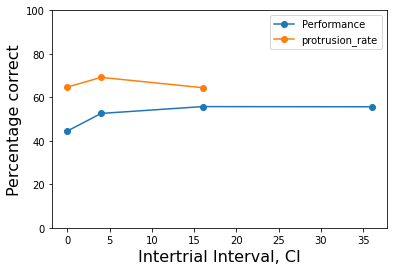

In [110]:
protrusion_rate = np.array(output_protrusions_c_i)/np.array(immediate_intrusions_c_i)
plt.plot(C_i_arr, np.array([perf_c_i]).squeeze()*100, marker='o', label='Performance')
plt.plot(C_i_arr, protrusion_rate*100, marker='o', label='protrusion_rate')
plt.ylim(0, 100)
plt.xlabel("Intertrial Interval, CI", fontsize=16)
plt.ylabel("Percentage correct", fontsize=16)
plt.legend()
plt.show()

In [98]:
demonstration_6_params = {'s0': 1.0, 'e0': 0.60, 'S':0.8 , 'E': 0.48, 'G_c': 0.08, 'G_p':0.14, 'R_s': 0.50, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'C_p': 1, 'C_d': 0, 'C_r': 1, 'C_i': 36, 'C_a': 5, 'A_p':1,
                        'P_s':1, 'P_d':0, 'vocab_size': 12, 'max_tokens':30}
num_trials = 5000
list_length = 6
group_length = 6
C_i_arr = [0, 4, 16, 36]
perf_c_i = []
intrusions_c_i = []
immediate_intrusions_c_i = []
output_protrusions_c_i = []
for c_i in C_i_arr:
    demonstration_5_params['C_i'] = c_i
    mtSEM_5 = MultiTrialSEM(demonstration_5_params)
    mtSEM_5.simulate_trials(num_trials, list_length, group_length)
    perf_c_i.append(mtSEM_5.num_correct / num_trials)
    intrusions_c_i.append(mtSEM_5.num_intrusions)
    immediate_intrusions_c_i.append(mtSEM_5.num_immediate_intrusions)
    output_protrusions_c_i.append(mtSEM_5.num_output_protrusions)
    print(f"PPR: {mtSEM_5.num_correct / num_trials}")
    print(f"Num omissions: {mtSEM_5.num_omissions}")
    print(f"Num intrusions: {mtSEM_5.num_intrusions}")
    print(f"Num immediate intrusions: {mtSEM_5.num_immediate_intrusions}")
    print(f"Num protrusions: {mtSEM_5.num_output_protrusions}")

KeyboardInterrupt: 

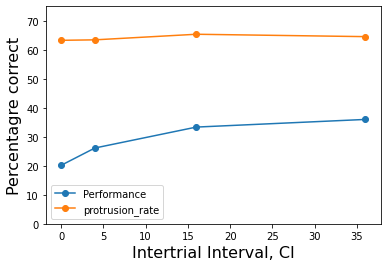

In [ ]:
protrusion_rate = np.array(output_protrusions_c_i)/np.array(immediate_intrusions_c_i)
plt.plot(C_i_arr, np.array([perf_c_i]).squeeze()*100, marker='o', label='Performance')
plt.plot(C_i_arr, protrusion_rate*100, marker='o', label='protrusion_rate')
plt.ylim(0, 75)
plt.xlabel("Intertrial Interval, CI", fontsize=16)
plt.ylabel("Percentagre correct", fontsize=16)
plt.legend()
plt.show()